## Import library

In [82]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
# from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template
import requests
import json


pd.set_option("max_colwidth", None)

## Collaborative Filtering

In [146]:
%cd "/content/drive/MyDrive/Year4/KTDLTTXH/data"
%ls

/content/drive/MyDrive/Year4/KTDLTTXH/data
dung.csv  full.csv  long.csv  metrics.png  ratings.png  vi/  vi.csv


In [147]:
import glob
import os

files = os.path.join("/content/drive/MyDrive/Year4/KTDLTTXH/data", "*.csv")
files = glob.glob(files)

print("Resultant CSV after joining all CSV files at a particular location...")
data = pd.concat(map(pd.read_csv, files), ignore_index=True)
del data["Unnamed: 0"]
del data["Unnamed: 0.1"]
del data["Unnamed: 0.1.1"]
del data["Unnamed: 0.1.1.1"]
del data["Index"]

print(data.info(), data.shape)
# data.to_csv("full.csv")
data.head(1)

Resultant CSV after joining all CSV files at a particular location...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93037 entries, 0 to 93036
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Shop_id              93037 non-null  int64  
 1   Shop_Name            93037 non-null  object 
 2   Prod_id              93037 non-null  int64  
 3   Prod_Name            93037 non-null  object 
 4   Description_Prod     89527 non-null  object 
 5   Price                93037 non-null  float64
 6   Average_Rating       93037 non-null  float64
 7   Total_Comments       93037 non-null  int64  
 8   User_Rating          88528 non-null  float64
 9   User_id              90229 non-null  float64
 10  User_Review          76162 non-null  object 
 11  URL                  93037 non-null  object 
 12  Description_Product  2772 non-null   object 
dtypes: float64(4), int64(3), object(6)
memory usage: 9.2+ MB
None (930

,Shop_id,Shop_Name,Prod_id,Prod_Name,Description_Prod,Price,Average_Rating,Total_Comments,User_Rating,User_id,User_Review,URL,Description_Product
0,45528688,Hani Healthy Food,15940877040,"1kg Hạt Sen Khô Đồng Tháp, Hàng Ngon Loại 1 Nấu Chè Cháo ❣️ Kho Sỉ Dinh Dưỡng HANI","🌱 THÔNG TIN SẢN PHẨM\n❗ Xuất xứ: Đồng Tháp\n❗ HSD: 12 tháng\n\t★ Thành phần: 100% hạt sen khô\n\t★ 100% tự nhiên, canh tác sạch\n\t★ Không thuốc trừ sâu, không hóa chất \n\t★ Giống thuần chủng, không biến đổi gen (Non-GMO)\n\nHạt sen trắng đục, hạt nhỏ xinh và đều, mùi vị thơm ngon ăn rất là bùi. Hàm lượng dinh dưỡng cao.\nCAM KẾT VỀ SẢN PHẨM: Hạt sen sạch 100% thiên nhiên, không chất bảo quản, không phụ gia, đảm bảo an toàn vệ sinh thực phẩm.\n\n🎧 THÀNH PHẦN DINH DƯỠNG\n\n\tHạt sen là hạt của cây sen, gồm có hai phần chính là hạt và tâm sen, có vị thanh mát, tính bình, dễ ăn. Hạt sen có thể sử dụng được ở cả hai dạng tươi và khô, là nguyên liệu cho nhiều món ăn khác nhau bởi đây là một loại hạt có thành phần dinh dưỡng rất cao, có nhiều tác dụng cho sức khỏe và sắc đẹp.\n\n\tHạt sen có vị ngọt, tính bình và chứa nhiều giá trị dinh dưỡng. Theo Đông y, hạt sen không chỉ là món ăn ngon, bổ, mà còn là vị thuốc quý, có tác dụng dưỡng tâm an thần, ích thận, bổ tỳ, chữa di tinh, mộng tinh, tiêu chảy, mất ngủ, chậm tiêu, đầy bụng, ăn kém, chữa khát do sốt cao, mất nước… đặc biệt những nghiên cứu gần đây cho thấy hạt sen còn có tác dụng rất lớn trong việc chống lão hóa và tăng cường sức khỏe người cao tuổi.\n\n👉 Hỗ trợ chứng mất ngủ, đau đầu\n👉 Bồi bổ cho bà bầu và thai nhi\n👉 Làm đẹp da\n👉 Hỗ trợ chống lão hóa\n👉 Điều hòa cholesterol và đường huyết\n👉 Cải thiện hệ thống tiêu hóa\n👉 Cung cấp năng lượng nhanh\n\n⚠️ CHÚ Ý NHA BÀ CON\nHạt sen khô không nên ngâm nước, sẽ làm hạt bị sượng. Chỉ nên rửa sạch, và nấu lúc nước ấm ấm ( không quá sôi, cũng không quá lạnh).\nNấu chè hạt sen thì không nên bỏ đường vô trước, khi nấu chín thì tắt lửa và cho đường vào, khuấy tan đường và khi đó hạt sen sẽ ăn ngon, bùi.\n\n👀 CÁCH BẢO QUẢN VÀ CHẾ BIẾN HẠT SEN KHÔ\n\t👉 Chè sen, mứt sen, chè sen long nhãn, xôi hạt sen, gà hầm hạt sen...\n\t👉 Làm sữa hạt sen, làm bánh hạt sen...\nCHÚ Ý: Bảo quản hạt sen khô ở nơi khô ráo, thoáng mát, đậy kín khi không xài. Nếu trữ số lượng hạt sen lớn thi thoảng bạn đem hạt phơi nắng to cho sen thơm và khô ráo.\n\n☑️ CAM KẾT ❗\n✔️ Hoàn tiền & Miễn phí đổi trả 07 ngày trong trường hợp:\n\t- Sản phẩm thực tế không giống như mô tả\n\t- Hàng bị lỗi, mốc, hỏng không thể sử dụng hoặc ảnh hưởng tới chất lượng\n\nPhân phối bởi Công ty TNHH Thực Phẩm Hani Việt Nam\nHotline: 094.969.5010\nĐịa chỉ: *Lô CC1 - Khu, 2 Nguyễn Văn Linh - Bình Chánh - HCM\n *Thôn Hải Hà - Xã Ea Tân - Krong Năng - Dak Lak\nTuyển sỉ/CTV toàn quốc\n\n#hạt_sen_khô #hatsenkho #sendongthap #hatsenngon #hat_sen #hat_sen_nau_che #hat_sen_kho_1kg #hạt_sen #hạt_sen",117856.12244,1.570925,12,5.0,9463240.0,"Hương vị:Hạt sen\nBao bì/Mẫu mã:Đơn giản, đẹp\n\nMua hạt sen khô dễ trữ làm sữa. Sản phẩm tốt",https://shopee.vn/1kg-H%E1%BA%A1t-Sen-Kh%C3%B4-%C4%90%E1%BB%93ng-Th%C3%A1p-H%C3%A0ng-Ngon-Lo%E1%BA%A1i-1-N%E1%BA%A5u-Ch%C3%A8-Ch%C3%A1o-%E2%9D%A3%EF%B8%8F-Kho-S%E1%BB%89-Dinh-D%C6%B0%E1%BB%A1ng-HANI-Food-i.45528688.15940877040?sp_atk=de070e3b-a6c3-4299-a7cd-1717e3174093&xptdk=de070e3b-a6c3-4299-a7cd-1717e3174093,NaN


In [148]:
ratings = data.dropna(subset=["User_id", "User_Rating", "Prod_id"])
# ratings = ratings.drop_duplicates(subset=["User_id", "User_Rating", "Prod_id"])
ratings = ratings[["User_id", "Prod_id", "User_Rating"]]
ratings

,User_id,Prod_id,User_Rating
0,9463240.0,15940877040,5.0
1,320629185.0,15940877040,5.0
2,774700227.0,15940877040,5.0
3,112133605.0,15940877040,5.0
4,91525994.0,15940877040,5.0
...,...,...,...
93026,576874288.0,13825733816,5.0
93030,229090458.0,6333550166,5.0
93031,121312494.0,6333550166,5.0
93032,98702403.0,6333550166,5.0


In [149]:
ratings.shape

(88528, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


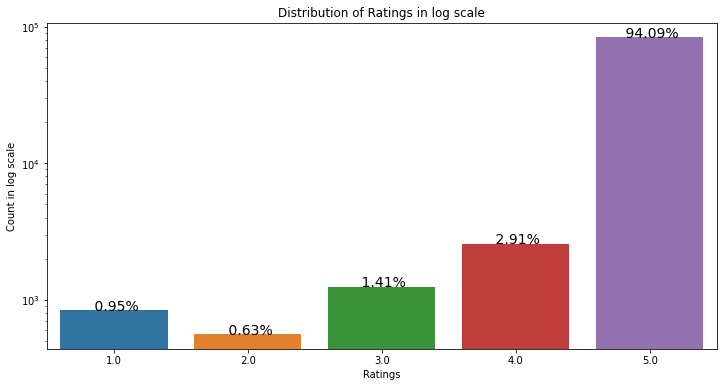

In [150]:
def countplot_with_percentages(serie):
    ax = sns.countplot(serie)
    total_count = serie.count()

    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        percentage = p.get_height() / total_count * 100
        ax.annotate(f'\n{percentage: .2f}%',
                    (x.mean(), y), ha='center', size=14)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.axes(yscale="log")

countplot_with_percentages(ratings.User_Rating)

plt.title("Distribution of Ratings in log scale")
plt.ylabel("Count in log scale")
plt.xlabel("Ratings");
plt.savefig("ratings.png")

In [151]:
len(ratings.Prod_id.unique())

746

In [152]:
users_count = ratings.groupby("User_id").size().reset_index()
users_count.columns = ["User_id", "Product_count"]

print(users_count.shape)

filtered_users = users_count[users_count.Product_count >= 10]
users = set(filtered_users.User_id)

print(len(users))
filtered_users.sort_values(by="Product_count")

(11566, 2)
2730


,User_id,Product_count
4590,86280414.0,10
9550,440540970.0,10
5764,130500659.0,10
8574,329547754.0,10
4500,84243689.0,10
...,...,...
1225,24086994.0,72
7025,204717603.0,75
7377,228359043.0,75
6580,175393350.0,81


In [153]:
ratings = ratings[ratings.User_id.isin(users)]
print ("ratings.shape:", ratings.shape)
print (ratings.info())

ratings.shape: (52008, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52008 entries, 53 to 93033
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   User_id      52008 non-null  float64
 1   Prod_id      52008 non-null  int64  
 2   User_Rating  52008 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.6 MB
None


In [154]:
unique_users = {int(x): i for i,x in enumerate(ratings.User_id.unique())}
unique_items = {int(x): i for i,x in enumerate(data.Prod_id.unique())}

print("Số lượng sản phẩm " + str(len(unique_items)) + ",", "Số lượng người dùng " + str(len(unique_users)))
prod_collabolative_filter = np.zeros((len(unique_items), len(unique_users)))

for user_id, prod_id, rating in ratings.values:
    prod_collabolative_filter[unique_items[prod_id], unique_users[user_id]] = rating

Số lượng sản phẩm 760, Số lượng người dùng 2730


In [155]:
ratings[ratings.Prod_id == 5738112273]

,User_id,Prod_id,User_Rating
235,204151064.0,5738112273,5.0
65560,204151064.0,5738112273,5.0
69173,204151064.0,5738112273,5.0


In [156]:
ratings

,User_id,Prod_id,User_Rating
53,357113906.0,11810253155,5.0
54,357113906.0,11810253155,5.0
235,204151064.0,5738112273,5.0
304,59204823.0,4909839416,5.0
336,282419047.0,9668539289,5.0
...,...,...,...
93026,576874288.0,13825733816,5.0
93030,229090458.0,6333550166,5.0
93031,121312494.0,6333550166,5.0
93032,98702403.0,6333550166,5.0


In [157]:
def get_recommended_KNN(vector, query_index, n_neighbors=10):
    model_knn = NearestNeighbors(metric='cosine', n_neighbors=n_neighbors)
    model_knn.fit(csr_matrix(vector))

    distances, indices = model_knn.kneighbors(vector[query_index,:].reshape(1, -1), n_neighbors = n_neighbors)
    print(vector[query_index,:].reshape(1, -1).shape)
    print("distances, indices:\n", distances, indices)
    result = []
    for i in range(0, len(distances.flatten())):
        index = indices.flatten()[i]
        if index == query_index:
          continue
        result.append(data.iloc[index])
    return pd.DataFrame(result)

In [158]:
print(unique_items)

{15940877040: 0, 2893983203: 1, 11810253155: 2, 7781587489: 3, 5529301545: 4, 2605212727: 5, 2900178866: 6, 9058175885: 7, 1836847764: 8, 10009933169: 9, 14430183701: 10, 4006093671: 11, 86230518: 12, 3943752514: 13, 10004129128: 14, 9897184943: 15, 12140231949: 16, 16461198686: 17, 5738112273: 18, 7518504936: 19, 9674735395: 20, 5548750336: 21, 6714767969: 22, 2790471691: 23, 8544897440: 24, 1745818327: 25, 4909839416: 26, 6436538212: 27, 7826075915: 28, 9960846437: 29, 8931831661: 30, 9623081801: 31, 2765137815: 32, 9668539289: 33, 6634587069: 34, 7536156929: 35, 11612645648: 36, 5336721067: 37, 2556319925: 38, 2593887462: 39, 10615661194: 40, 5125581895: 41, 8478048430: 42, 9469790711: 43, 667836517: 44, 4331989304: 45, 11493877357: 46, 9148156780: 47, 1050130080: 48, 8873773256: 49, 6194244871: 50, 6074763179: 51, 10712644821: 52, 7192300244: 53, 15618189399: 54, 12162255992: 55, 3062205414: 56, 4890368395: 57, 2559224908: 58, 4793426092: 59, 10563137790: 60, 5015390629: 61, 736034

In [167]:
query_index = ratings[ratings.Prod_id == 6186923436].index
query_index

Int64Index([], dtype='int64')

In [169]:
get_recommended_KNN(prod_collabolative_filter, 300, 5)

(1, 2730)
distances, indices:
 [[1. 1. 1. 1. 1.]] [[506 504 508 507 510]]


,Shop_id,Shop_Name,Prod_id,Prod_Name,Description_Prod,Price,Average_Rating,Total_Comments,User_Rating,User_id,User_Review,URL,Description_Product
506,477743977,haisanmekong,10615661194,"Khô cá dứa cần giờ 1kg , phi lê không xương ngon miệng vừa ăn/thịt dày thơm ngon không chất bảo quản Mekong","Khô cá dứa cần giờ 1kg , phi lê không xương ngon miệng vừa ăn/thịt dày thơm ngon không chất bảo quản Mekong Foods\n-------------------------------------------------\n+ Quy cách đóng gói : Khô cá dứa 3 nắng được phơi khô 3 nắng và hút chân không trước khi bỏ vào thùng carton giao đến quý khách kèm giấy hướng dẫn chế biến\n+ Xuất xứ : Cần Giờ / Phân Phối và bán hàng :Hải Sản mekong\n+ Hạn sử dụng : 6 Tháng kể từ ngày đóng gói (Bảo quản lạnh)\n+ Nguyên liệu : Chế biến từ nguồn cá tươi ngon được ngư dân đánh bắt và được đem phơi sấy bằng nắng tự nhiên\n+ Quy trình chế biến : Thủ công - Truyền thống. Hoàn toàn tự nhiên \n+ Cách dùng : Dùng để chế biến các món như nướng , chiên , rán , xào...\n+ Tiêu chuẩn chất lượng : Đạt tiêu chuẩn sạch, KHÔNG hóa chất, KHÔNG phẩm màu, đảm bảo VSATTP.hình thức kinh doanh sỉ và lẻ. (sỉ liên hệ giá tốt nhất thị trường )\n+ Vận chuyển : Toàn quốc và phục vụ vận chuyển cho kiều bào nước ngoài (Nhà mình nhớ sưu tầm mã FREESHIP EXTRA và Follow shop để tiết kiệm chi phí vận chuyển và nhận được nhiều mã giảm giá nhé )\n\nAnh chị mua hàng gởi đi nước ngoài nhắn tin để SHOP lưu ý cách vận chuyển cho anh chị \n\n• Hiện nay có hàng ngàn đơn vị kinh doanh hải sản khô trên toàn quốc, nhưng Hải Sản Mekong vẫn chiếm trọn sự tin yêu của khách hàng và có cho mình một lượng khách hàng ổn định. Đơn giản bởi chúng tôi mang tới cho khách hàng chất lượng sản phẩm tốt nhất, cung cách phục vụ chuyên nghiệp nhất: \n• Hải sản được lựa chọn kỹ càng từ những vựa hải sản lớn trên khắp cả nước, đảm bảo chất lượng hải sản tốt nhất, thơm ngon nhất như Quảng Ninh, Hải Phòng, Nghệ An, Nha Trang, Phú Quốc… Tất cả hải sản được chọn lọc để sấy khô, phơi một nắng đều là hải sản tươi ngon, không phải hải sản đã chết ươn, chất lượng kém. Do đó, khi ăn, bạn sẽ thấy hương vị thơm ngon, dai dai của cá, của tôm như khi còn tươi, thay vì vị bở bở và mùi khó chịu của cá tôm đã bị chết, ươn trước khi làm khô mà nhiều đơn vị đang bày bán. \n• Hải sản được lấy tận gốc, không thông qua trung gian nên mức giá hợp lý, cạnh tranh trên thị trường. \n• Chúng tôi có 2 cơ sở tại miền Bắc và miền Nam với đội ngũ nhân viên bán hàng chuyên nghiệp, giao hàng tận tình, sẵn sàng phục vụ quý khách hàng 24/7. Đảm bảo giao hàng nhanh chóng trong vòng 2 – 4 giờ theo yêu cầu của khách hàng. \n• Với khách hàng ở tỉnh xa, chúng tôi hỗ trợ vận chuyển tận nơi theo đúng đơn hàng mà khách hàng đã đặt. Cam kết chuẩn số lượng, chất lượng và mức giá đã thống nhất. \n• Trong trường hợp khách hàng nhận hàng và cảm thấy không hài lòng về chất lượng sản phẩm. Có thể phản hồi ngay cho chúng tôi theo số hotline để được đổi trả, hoàn tiền theo đúng quy định.\n\n#khô_cá_dứa #khocadua #khocadua3nang #khocadua1nang\n#cakho #cá_khô #cá_sấy_khô\n#haisansaykho #hải_sản_sấy_khô\n#dacsanthientu #đặc_sản_thiên_tú\n#cadacsan #món_nhậu #monnhau\n#cangon #catam #cá_tẩm\n#cakhothientu \n#cá_chỉ_vàng \n#khô_cá_chỉ_vàng \n#cá_khô #khô_cá_kèo\n#đặc_sản \n#quà_tặng #quà",129875.53877,0.753005,34,5.0,18859661.0,"Khô cá được cắt miếng và đóng gói hút chân không rất sạch sẽ, chưa ăn nên chưa nhận xét được.",https://shopee.vn/Kh%C3%B4-c%C3%A1-d%E1%BB%A9a-c%E1%BA%A7n-gi%E1%BB%9D-1kg-phi-l%C3%AA-kh%C3%B4ng-x%C6%B0%C6%A1ng-ngon-mi%E1%BB%87ng-v%E1%BB%ABa-%C4%83n-th%E1%BB%8Bt-d%C3%A0y-th%C6%A1m-ngon-kh%C3%B4ng-ch%E1%BA%A5t-b%E1%BA%A3o-qu%E1%BA%A3n-Mekong-Foods-i.477743977.10615661194?sp_atk=9f75a6db-3999-4c72-82c1-c592960d3563&xptdk=9f75a6db-3999-4c72-82c1-c592960d3563,NaN
504,477743977,haisanmekong,10615661194,"Khô cá dứa cần giờ 1kg , phi lê không xương ngon miệng vừa ăn/thịt dày thơm ngon không chất bảo quản Mekong","Khô cá dứa cần giờ 1kg , phi lê không xương ngon miệng vừa ăn/thịt dày thơm ngon không chất bảo q

## Train Test Split

In [21]:
df = ratings

In [22]:
n_users = df.User_id.unique().shape[0]
n_prods = df.Prod_id.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_prods) + ' items')

2730 users
354 items


In [23]:
ratings=pd.pivot_table(df,values='User_Rating',index='User_id',columns='Prod_id')
pd.DataFrame(ratings.notna().sum(axis=1), columns=['Count of ratings']).max()

Count of ratings    5
dtype: int64

In [24]:
ratings=pd.pivot_table(df,values='User_Rating',index='User_id',columns='Prod_id')
ratings.fillna(0, inplace=True)
ratings

Prod_id,247272852,248659792,399850688,534746504,667836517,736034050,781598469,797804359,875169690,1014102778,...,16418593154,16647606615,17225203522,17345350279,17815200873,17828505386,17854548113,17861986730,18700584253,20501110169
User_id,,,,,,,,,,,,,,,,,,,,,
109984.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125606.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
382653.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
383647.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409460.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775275570.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
779409163.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
780895594.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
ratings=ratings.values
print(ratings)
sparsity = float(len(pd.isna(ratings[0])))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Sparsity: 0.04%


In [26]:
def train_test_split(ratings, x):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=x, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    # assert(np.all((train * test) == 0)) 
    return train, test

In [27]:
train, test = train_test_split(ratings,1)
np.all(train*test) == 0

True

In [28]:
k = [1]
train = []
test = []
for i in k:
  train_, test_ = train_test_split(ratings, i)
  train.append(train_)
  test.append(test_)

In [29]:
def slow_similarity(ratings, kind='user'):
    if kind == 'user':
        axmax = 0
        axmin = 1
    elif kind == 'item':
        axmax = 1
        axmin = 0
    sim = np.zeros((ratings.shape[axmax], ratings.shape[axmax]))
    for u in xrange(ratings.shape[axmax]):
        for uprime in xrange(ratings.shape[axmax]):
            rui_sqrd = 0.
            ruprimei_sqrd = 0.
            for i in xrange(ratings.shape[axmin]):
                sim[u, uprime] = ratings[u, i] * ratings[uprime, i]
                rui_sqrd += ratings[u, i] ** 2
                ruprimei_sqrd += ratings[uprime, i] ** 2
            sim[u, uprime] /= rui_sqrd * ruprimei_sqrd
    return sim

def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [30]:
def predict_slow_simple(ratings, similarity, kind='user'):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in xrange(ratings.shape[0]):
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :].dot(ratings[:, j])\
                             /np.sum(np.abs(similarity[i, :]))
        return pred
    elif kind == 'item':
        for i in xrange(ratings.shape[0]):
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[j, :].dot(ratings[i, :].T)\
                             /np.sum(np.abs(similarity[j, :]))

        return pred

def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

def get_rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual)), mean_squared_error(pred, actual), mean_absolute_error(pred, actual), median_absolute_error(pred, actual)

In [32]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [33]:
for i in range(1):
  user_similarity = fast_similarity(train[i], kind='user')
  item_similarity = fast_similarity(train[i], kind='item')
  item_prediction = predict_fast_simple(train[i], item_similarity, kind='item')
  user_prediction = predict_fast_simple(train[i], user_similarity, kind='user')

  print('User-based CF RMSE: ' + str(get_rmse(user_prediction, test[i])))
  print('Item-based CF RMSE: ' + str(get_rmse(item_prediction, test[i])))

  pred = predict_topk(train[i], user_similarity, kind='user', k=40)
  print('Top-k User-based CF RMSE: ' + str(get_rmse(pred, test[i])))
  pred = predict_topk(train[i], item_similarity, kind='item', k=40)
  print('Top-k Item-based CF RMSE: ' + str(get_rmse(pred, test[i])))

User-based CF RMSE: (4.912007165977116, 24.12781439861054, 4.88461823809912, 5.0)
Item-based CF RMSE: (4.911183194170613, 24.11972036670387, 4.883639156551216, 5.0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Top-k User-based CF RMSE: (4.911975593609929, 24.127504232219618, 4.884574290691121, 5.0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Top-k Item-based CF RMSE: (4.911180213701529, 24.119691091453397, 4.883635060440479, 5.0)


In [34]:
k_array = [1]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train[0], user_similarity, kind='user', k=k)
    item_pred = predict_topk(train[0], item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train[0])]
    user_test_mse += [get_mse(user_pred, test[0])]
    
    item_train_mse += [get_mse(item_pred, train[0])]
    item_test_mse += [get_mse(item_pred, test[0])] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an erro

In [35]:
get_recommended_KNN(train[0], 10, 10)

(1, 354)
distances, indices:
 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]] [[1822 1824 1815 1816 1817 1818 1819 1820 1821 1813]]


,Shop_id,Shop_Name,Prod_id,Prod_Name,Description_Prod,Price,Average_Rating,Total_Comments,User_Rating,User_id,User_Review,URL,Description_Product
1822,91680258,Shop ăn vặt Mẹ Gold,7602811075,Bánh quẩy tai heo (,Quẩy sò vị cay chiên giòn tan ăn ngon miệng. Thích hợp cho tất cả các cuộc tám chuyện hay có thể thưởng thức 1 mình với các bạn thích ăn vặt rất ngon ạ\n***\nXuất xứ: Việt Nam\nHạn sử dụng : 6 tháng từ ngày sản xuất in trên ba,17516.28092,1.060379,272,5.0,79940774.0,"Bánh bị vụn nhiều chắc do quá trình vận chuyển, bánh ngon, nhưng ko cay lắm cay hơn xíu nữa thì best👍🏻👍🏻👍🏻",https://shopee.vn/B%C3%A1nh-qu%E1%BA%A9y-tai-heo-(500g)-i.91680258.7602811075?sp_atk=ce2bfb93-b78a-4894-acb7-51fe24c492e7&xptdk=ce2bfb93-b78a-4894-acb7-51fe24c492e7,NaN
1824,91680258,Shop ăn vặt Mẹ Gold,7602811075,Bánh quẩy tai heo (,Quẩy sò vị cay chiên giòn tan ăn ngon miệng. Thích hợp cho tất cả các cuộc tám chuyện hay có thể thưởng thức 1 mình với các bạn thích ăn vặt rất ngon ạ\n***\nXuất xứ: Việt Nam\nHạn sử dụng : 6 tháng từ ngày sản xuất in trên ba,17516.28092,1.060379,272,5.0,514611746.0,"Snack ngon lứm mngg ơi, như hình nhé, nên mua, mình lỡ ăn hết mới nhớ ra đánh giá nên k có ảnh TvT",https://shopee.vn/B%C3%A1nh-qu%E1%BA%A9y-tai-heo-(500g)-i.91680258.7602811075?sp_atk=ce2bfb93-b78a-4894-acb7-51fe24c492e7&xptdk=ce2bfb93-b78a-4894-acb7-51fe24c492e7,NaN
1815,91680258,Shop ăn vặt Mẹ Gold,7602811075,Bánh quẩy tai heo (,Quẩy sò vị cay chiên giòn tan ăn ngon miệng. Thích hợp cho tất cả các cuộc tám chuyện hay có thể thưởng thức 1 mình với các bạn thích ăn vặt rất ngon ạ\n***\nXuất xứ: Việt Nam\nHạn sử dụng : 6 tháng từ ngày sản xuất in trên ba,17516.28092,1.060379,272,4.0,50246510.0,"Bánh có độ cay vừa phải, không bị nồng gia vị, shop cân đủ số lượng nhưng bánh bị vỡ vụn nhiều quá",https://shopee.vn/B%C3%A1nh-qu%E1%BA%A9y-tai-heo-(500g)-i.91680258.7602811075?sp_atk=ce2bfb93-b78a-4894-acb7-51fe24c492e7&xptdk=ce2bfb93-b78a-4894-acb7-51fe24c492e7,NaN
1816,91680258,Shop ăn vặt Mẹ Gold,7602811075,Bánh quẩy tai heo (,Quẩy sò vị cay chiên giòn tan ăn ngon miệng. Thích hợp cho tất cả các cuộc tám chuyện hay có thể thưởng thức 1 mình với các bạn thích ăn vặt rất ngon ạ\n***\nXuất xứ: Việt Nam\nHạn sử dụng : 6 tháng từ ngày sản xuất in trên ba,17516.28092,1.060379,272,5.0,48044912.0,ngon mà hơi ít sẽ ủng hộ gói nài típ cho shop giao cũng nhanh nữa,https://shopee.vn/B%C3%A1nh-qu%E1%BA%A9y-tai-heo-(500g)-i.91680258.7602811075?sp_atk=ce2bfb93-b78a-4894-acb7-51fe24c492e7&xptdk=ce2bfb93-b78a-4894-acb7-51fe24c492e7,NaN
1817,91680258,Shop ăn vặt Mẹ Gold,7602811075,Bánh quẩy tai heo (,Quẩy sò vị cay chiên giòn tan ăn ngon miệng. Thích hợp cho tất cả các cuộc tám chuyện hay có thể thưởng thức 1 mình với các bạn thích ăn vặt rất ngon ạ\n***\nXuất xứ: Việt Nam\nHạn sử dụng : 6 tháng từ ngày sản xuất in trên ba,17516.28092,1.060379,272,5.0,82774958.0,Nên mua nhé mọi người. Hình ảnh mang tính chất nhận xu thôi ạ .h h,https://shopee.vn/B%C3%A1nh-qu%E1%BA%A9y-tai-heo-(500g)-i.91680258.7602811075?sp_atk=ce2bfb93-b78a-4894-acb7-51fe24c492e7&xptdk=ce2bfb93-b78a-4894-acb7-51fe24c492e7,NaN
1818,91680258,Shop ăn vặt Mẹ Gold,7602811075,Bánh quẩy tai heo (,Quẩy sò vị cay chiên giòn tan ăn ngon miệng. Thích hợp cho tất cả các cuộc tám chuyện hay có thể thưởng thức 1 mình với các bạn thích ăn vặt rất ngon ạ\n***\nXuất xứ: Việt Nam\nHạn sử dụng : 6 tháng từ ngày sản xuất in trên ba,17516.28092,1.060379,272,5.0,20124383.0,Hình ảnh không liên quan đến nhưng chất lượng sản phẩm này tốt lắm ạ,https://shopee.vn/B%C3%A1nh-qu%E1%BA%A9y-tai-heo-(500g)-i.91680258.7602811075?sp_atk=ce2bfb93-b78a-4894-acb7-51fe24c492e7&xptdk=ce2bfb93-b78a-4894-acb7-51fe24c492e7,NaN
1819,91680258,Shop ăn vặt Mẹ Gold,7602811075,Bánh quẩy tai heo (,Quẩy sò vị cay chiên giòn tan ăn ngon miệng. Thích hợp cho tất cả các cuộc tám chuyện hay có thể thưởng thức 1 mình với các bạn thích ăn vặt rất ngon ạ\n***\nXuất xứ: Việt Nam\nHạn sử dụng : 6 tháng từ ngày sản xuất in trên ba,17516.28092,1.060379,272,5.0,423875662.0,"